# Cómo descubrir una nueva partícula

In [1]:
# Importar todos los módulos necesarios. Pandas es para análisis de datos, numpy es para cálculos científicos
# y matplotlib.pyplot es para hacer gráficas. Los módulos son llamados pd, np y plt.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def mll(dataset):
    return np.sqrt(2*dataset.pt1*dataset.pt2*(np.cosh(dataset.eta1-dataset.eta2) - np.cos(dataset.phi1-dataset.phi2)))

# Crear una nueva estructura de marco de datos desde el archivo "Zmumu_Run2011A_masses.csv"
dataset_mm = pd.read_csv('../Datos/DoubleMuRun2011A.csv')

In [2]:
from scipy.optimize import curve_fit

def expo(x, *params):
    """ An exponential curve. *NB* The constant is in the exponent! 
    params: const, slope """
    const, slope = params
    return np.exp(const + slope*x)

def gaus(x, *params):
    # An un-normalized Gaussian curve.
    # params: N, mu, sigma """abs
    N, mu, sigma = params
    return N*np.exp(-0.5 * ((x-mu)/sigma)**2 )

def gaus_exp(x, *params):
    # An un-normalized Gaussian curve.
    # params: N, mu, sigma """abs
    N, mu, sigma, const, slope = params
    return N*(np.exp(-0.5 * ((x-mu)/sigma)**2 )) +  np.exp(const + slope*x) 

def crystal_ball(x, *params):
    """ A Gaussian curve on one side and a power-law on the other side. Used in
    physics to model lossy processes.
    See http://en.wikipedia.org/wiki/Crystal_Ball_function
  Note that the definition used here differs slightly. At the time of this
  writing, the wiki article has some discrepancies in definitions/plots. This
  definition makes it easier to fit the function by using complex numbers
  and by negating any negative values for a and n.
  This version of the crystal ball is normalized by an additional parameter.
  params: N, a, n, xb, sig
  """
    x = x+0j # Prevent warnings...
    N, a, n, xb, sig = params
    if a < 0:
        a = -a
    if n < 0:
        n = -n
    aa = abs(a)
    A = (n/aa)**n * np.exp(- aa**2 / 2)
    B = n/aa - aa
    total = 0.*x
    total += ((x-xb)/sig  > -a) * N * np.exp(- (x-xb)**2/(2.*sig**2))
    total += ((x-xb)/sig <= -a) * N * A * (B - (x-xb)/sig)**(-n)
    try:
        return total.real
    except:
        return total
    return total


def crystal_ball_exp(x, *params):
    """ A Gaussian curve on one side and a power-law on the other side. Used in
    physics to model lossy processes.
    See http://en.wikipedia.org/wiki/Crystal_Ball_function
  Note that the definition used here differs slightly. At the time of this
  writing, the wiki article has some discrepancies in definitions/plots. This
  definition makes it easier to fit the function by using complex numbers
  and by negating any negative values for a and n.
  This version of the crystal ball is normalized by an additional parameter.
  params: N, a, n, xb, sig
  """
    x = x+0j # Prevent warnings...
    N, a, n, xb, sig, const, slope = params
    if a < 0:
        a = -a
    if n < 0:
        n = -n
    aa = abs(a)
    A = (n/aa)**n * np.exp(- aa**2 / 2)
    B = n/aa - aa
    total = 0.*x
    total += ((x-xb)/sig  > -a) * N * np.exp(- (x-xb)**2/(2.*sig**2))
    total += ((x-xb)/sig <= -a) * N * A * (B - (x-xb)/sig)**(-n)
    total += N*np.exp(const + slope*x) 
    try:
        return total.real
    except:
        return total
    return total

    
def cruijff(x, *params):
    n, mu, sig, alphaL, alphaR = params
    x = x+0j # Prevent warnings...
    dx = x-mu
    
    f =  2*sig*sig
    f += (dx<0)*alphaL*dx*dx
    f += (dx>0)*alphaR*dx*dx
    sol = n * (np.exp(-dx*dx/f))
    try: 
        return sol.real
    except:
        return sol
    return sol 




def centers_from_borders(borders):
    return borders[:-1] + np.diff(borders) / 2

# Plot the histogram and the fitted function.
xspace=np.linspace(60,120,1000)

### 2) Creando histogramas

A continuación crearemos histogramas separados de la masa invariante para los eventos con pseudo-rapidez grande y para los eventos con pseudo-rapidez pequeña. Con los histogramas podemos comparar las dos situaciones. 

### Histograma de masa invariante

Empecemos con los eventos donde la pseudo-rapidez de ambos muones ha sido grande. Ejecute el código haciendo clic en la casilla del código y luego presionando _Ctrl_ + _Enter_.

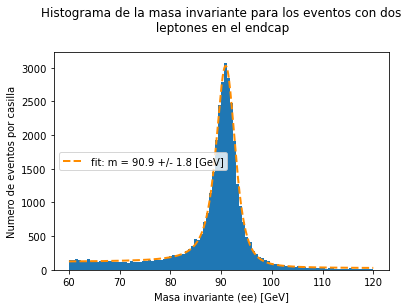

In [3]:
# Guardar la masa invariante a la variable "inv_mass1".
#mll_mm = mll(dataset_mm)

# Jupyter Notebook utiliza "funciones mágicas". Con esta función es posible graficar
# el histograma directamente en el cuaderno. 
%matplotlib inline

# Crear el histograma desde los datos en la variable "inv_mass1". Establecer el rango y número de casillas. 
n_mm, bins_mm, _ = plt.hist(dataset_mm.M, bins=100, range=[60,120])
x_mm = centers_from_borders(bins_mm)


par_g, par_cov_g = curve_fit(gaus, x_mm, n_mm, p0 = [1, 90, 1.]) 
par_cr, par_cov_cr = curve_fit(cruijff, x_mm, n_mm, p0 = [par_g[0], par_g[1], par_g[2],0.19,0.01], 
                               bounds=((0,par_g[1]-0.5*par_g[2],0,0,0),(1.1*par_g[0],par_g[1]+0.5*par_g[2],1.2*par_g[2],2,2)),
                               method='trf')

plt.plot(xspace, cruijff(xspace,*par_cr ), '--', color='darkorange', linewidth=2, label='fit: m = %3.1f +/- %3.1f [GeV]' %(par_cr[1],par_cr[2])) 

# Establecer el eje y en el rango de 0 a 60.
#axes = plt.gca()
#axes.set_ylim([0,2500])

# Nombrar los ejes y darles un título.
plt.xlabel('Masa invariante (ee) [GeV]')
plt.ylabel('Numero de eventos por casilla')
plt.title('Histograma de la masa invariante para los eventos con dos\n leptones en el endcap\n')
plt.legend()
plt.show()


Nbins = 15
mll_low  = 110
mll_high = 140

### Compare data to fit

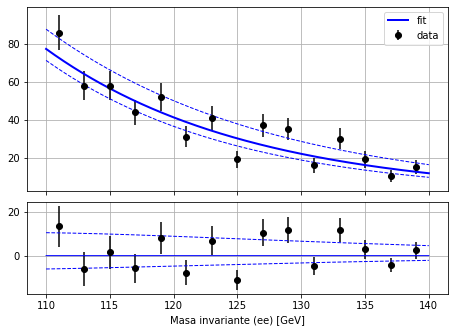

In [23]:
m_H = np.random.normal(125.10,1.,200)
m_ll = dataset_mm.M

counts,bin_edges = np.histogram(m_ll,Nbins,range=[mll_low,mll_high])
bin_centres = centers_from_borders(bin_edges)
err = np.sqrt(counts)

fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios': [2, 1]})
fig.tight_layout(pad=-1.0)

axs[0].errorbar(bin_centres, counts, yerr=err, fmt='o', color='black', label='data')

par_exp, par_cov_exp = curve_fit(expo, bin_centres, counts, sigma=err, p0 = [1., 1.]) 

errors = err
par_exp_1sigup, par_cov_exp = curve_fit(expo, bin_centres, counts+errors, p0 = [1., 1.]) 
par_exp_1sigdn, par_cov_exp = curve_fit(expo, bin_centres, counts-errors, p0 = [1., 1.]) 

xspace=np.linspace(110,140,10000)
axs[0].plot(xspace, expo(xspace,*par_exp ), '-', color='blue', linewidth=2, label='fit') 
axs[0].plot(xspace, expo(xspace, *par_exp_1sigup ), '--', color='blue', linewidth=1) 
axs[0].plot(xspace, expo(xspace, *par_exp_1sigdn ), '--', color='blue', linewidth=1) 

ratio     = counts-expo(bin_centres,*par_exp)
ratio_err = err

axs[1].errorbar(bin_centres, ratio, yerr=ratio_err, fmt='o', color='black', label='data')
axs[1].plot(xspace, np.zeros_like(xspace), '-', color='blue', linewidth=1, label='fit') 
axs[1].plot(xspace, expo(xspace, *par_exp_1sigup )-expo(xspace,*par_exp ), '--', color='blue', linewidth=1, label='fit') 
axs[1].plot(xspace, expo(xspace, *par_exp_1sigdn )-expo(xspace,*par_exp ), '--', color='blue', linewidth=1, label='fit') 
axs[0].axes.set_xticklabels([])

# Nombrar los ejes y darles un título. 
plt.xlabel('Masa invariante (ee) [GeV]')
axs[0].legend()
axs[1].grid()
axs[0].grid()
plt.show()

### Injecting signal

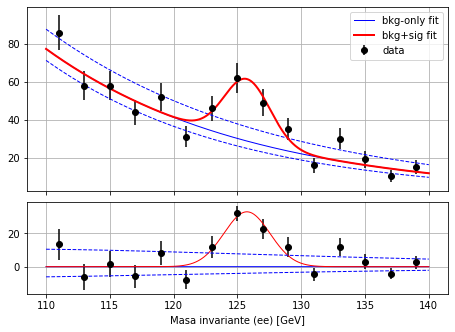

In [24]:
from scipy.integrate import quad

N_signal = 60

m_H = np.random.normal(125.10,1.,200)
m_ll = dataset_mm.M

mH_counts,edges = np.histogram(m_H[0:N_signal],Nbins,range=[mll_low,mll_high])   
sig_bkg=counts+mH_counts
mH_err = np.sqrt(sig_bkg)
sig_bkg_err=np.sqrt(sig_bkg)

fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios': [2, 1]})
fig.tight_layout(pad=-1.0)

axs[0].errorbar(bin_centres, sig_bkg, yerr=mH_err, fmt='o', color='black', label='data')

par_ge, _ = curve_fit(gaus_exp, bin_centres, sig_bkg, sigma=sig_bkg_err, p0 = [30.,125.,2., par_exp[0], par_exp[1]],
                      bounds=((20,110.,0.,0.9999999999*par_exp[0],1.000000001*par_exp[1]),(40,140.,5.,1.00000000001*par_exp[0],0.9990009999*par_exp[1])),
                      method='trf') 


xspace=np.linspace(110,140,10000)
axs[0].plot(xspace, expo(xspace,*par_exp ), '-', color='blue', linewidth=1, label='bkg-only fit') 
axs[0].plot(xspace, expo(xspace, *par_exp_1sigup ), '--', color='blue', linewidth=1) 
axs[0].plot(xspace, expo(xspace, *par_exp_1sigdn ), '--', color='blue', linewidth=1) 
axs[0].plot(xspace, gaus_exp(xspace,*par_ge ), '-', color='red', linewidth=2, label='bkg+sig fit') 

ratio     = sig_bkg-expo(bin_centres,*par_exp)
ratio_err = err

axs[1].errorbar(bin_centres, ratio, yerr=ratio_err, fmt='o', color='black')
axs[1].plot(xspace, np.zeros_like(xspace), '-', color='blue', linewidth=1) 
axs[1].plot(xspace, gaus_exp(xspace,*par_ge )-expo(xspace,*par_exp ), '-', color='red', linewidth=1) 
axs[1].plot(xspace, expo(xspace, *par_exp_1sigup )-expo(xspace,*par_exp ), '--', color='blue', linewidth=1) 
axs[1].plot(xspace, expo(xspace, *par_exp_1sigdn )-expo(xspace,*par_exp ), '--', color='blue', linewidth=1) 

axs[0].axes.set_xticklabels([])

# Nombrar los ejes y darles un título. 
plt.xlabel('Masa invariante (ee) [GeV]')
axs[0].legend()
axs[1].grid()
axs[0].grid()
plt.show()


### 3) Cálculo de p-valores y significancia estadística

[From (Cowan, Statistical Data Analysis)] 

A simple type of goodness-of-fit test is often carried out to judge whether a discrepancy between data and expectation is sufficiently significant to merit a claim for a new discovery . Here one may see evidence for a special type of signal event, the number $n_s$ of which can be treated as a Poisson variable with mean $\nu_s$. In addition to the signal events, however, one will find in general a certain number of background events $n_b$. Suppose this can also be treated as a Poisson variable with mean $\nu_b$, which we will assume for the moment to be known without error.  The total number of events found, $n = n_s + n_b$, is therefore a Poisson variable with mean $\nu = \nu_s + \nu_b$. The probability to observe $n$ events is thus

$f(n; \nu_s, \nu_b) = \frac{(\nu_s+\nu_b)^n}{n!} e^{-(\nu_s+\nu_b)} $

Suppose we have carried out the experiment and found $n_{obs}$ events. In order to quantify our degree of confidence in the discovery of a new effect, i.e. $\nu_s \neq 0$, we can compute how likely it is to find $n_{obs}$ events or more from background alone. This is given by

$P(n\geq n_{obs}) = \sum_{n=n_{obs}}^{\infty} f(n; \nu_s=0, \nu_b) =  \sum_{n=0}^{n_{obs}-1} f(n; \nu_s=0, \nu_b) = 1 - \sum_{n=0}^{n_{obs}-1} \frac{\nu_b^n}{n!} e^{-\nu_b}  $


Total number of ``background'' events: 152 +/- 38
Total number of ``observed signal'' events: 73
The p-value of observing those signal events is 2.036e-08
The significance is 5.944


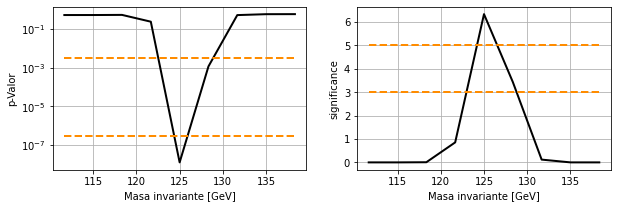

In [35]:
norm = (140-110)/len(bin_centres)

F_bkg = quad(expo, 120., 130., args=(par_exp[0],par_exp[1]))
F_bkg_up = quad(expo, 120., 130., args=(par_exp_1sigup[0],par_exp_1sigup[1]))
F_sig = quad(gaus_exp, 120., 130., args=(par_ge[0],par_ge[1],par_ge[2],par_ge[3],par_ge[4]))

N_bkg = F_bkg[0]/norm
N_sig = (F_sig[0]-F_bkg[0])/norm
    
print("Total number of ``background'' events: %d +/- %d" %(N_bkg,abs((F_bkg_up[0])/(norm)-N_bkg)))
print("Total number of ``observed signal'' events: %d" %(N_sig)) 

from scipy.stats import poisson
print("The p-value of observing those signal events is %4.3e" %(poisson.sf( N_bkg+N_sig-1, N_bkg)))
print("The significance is %4.3f" %(N_sig/np.sqrt(N_bkg)))

### do a sliding window of 10 GeV
N_bkg = []
N_sig = []
pVal = []
sig = []
m = np.linspace(110,140,10)
for i in range(len(m)-1):
    F_bkg = quad(expo, m[i], m[i+1], args=(par_exp[0],par_exp[1]))
    F_bkg_up = quad(expo, m[i], m[i+1], args=(par_exp_1sigup[0],par_exp_1sigup[1]))
    F_sig = quad(gaus_exp, m[i], m[i+1], args=(par_ge[0],par_ge[1],par_ge[2],par_ge[3],par_ge[4]))

    N_bkg.append(F_bkg[0]/norm)
    N_sig.append((F_sig[0]-F_bkg[0])/norm)

    pVal.append(poisson.sf( N_bkg[i]+N_sig[i]-1, N_bkg[i]))
    
sig = N_sig/np.sqrt(N_bkg)

 #   print("Total number of ``background'' events: %d +/- %d" %(N_bkg[i],abs((F_bkg_up[0])/(norm)-N_bkg[i])))
 #   print("Total number of ``observed signal'' events: %d" %(N_sig[i])) 

m_x = centers_from_borders(m)

f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.semilogy(m_x, pVal, '-', color='black', linewidth=2)
ax.semilogy(m_x,np.full_like(m_x,0.003), '--', color='darkorange', linewidth=2)
ax.semilogy(m_x,np.full_like(m_x,0.0000003), '--', color='darkorange', linewidth=2)
ax.set_xlabel('Masa invariante [GeV]')
ax.set_ylabel('p-Valor')
ax.grid()

ax2.plot(m_x, sig, '-', color='black', linewidth=2)
ax2.plot(m_x,np.full_like(m_x,3), '--', color='darkorange', linewidth=2)
ax2.plot(m_x,np.full_like(m_x,5), '--', color='darkorange', linewidth=2)
ax2.set_xlabel('Masa invariante [GeV]')
ax2.set_ylabel('significance')
ax2.grid()

plt.show()